When preparing a dataset for machine learning, a common step is to reduce dimensions using [principal component analysis (PCA)](https://georgemdallas.wordpress.com/2013/10/30/principal-component-analysis-4-dummies-eigenvectors-eigenvalues-and-dimension-reduction/). This is often necessary when multi-collinearity is an issue. Multi-collinearity is often encountered in multi- and hyper-spectral satellite data, where individual channels do not add much information to that carried by their neighbors.

Here I use data from the [Hyperspectral Imager for the Coastal Ocean (HICO)](http://hico.coas.oregonstate.edu/).


In [1]:
import netCDF4 as nc
import sys
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import xarray as xr
import pandas as pd
import os
import matplotlib.pyplot as pl
from matplotlib import rcParams
import numpy as np
from seaborn import heatmap
import cmocean as cm

/accounts/ekarakoy/anaconda3/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
print("versions:")
print("python: %s" % sys.version)
print("nc: %s" % nc.__version__)
print("pd: %s" % pd.__version__)
print("xr: %s" % xr.__version__)
print("np: %s" % np.__version__)

versions:
python: 3.6.3 | packaged by conda-forge | (default, Oct  5 2017, 14:07:33) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]
nc: 1.3.0
pd: 0.20.3
xr: 0.9.6
np: 1.13.3


In [3]:
% matplotlib inline

In [4]:
rcParams['xtick.labelsize'] = 14
rcParams['ytick.labelsize'] = 14
rcParams['axes.titlesize'] = 18
rcParams['font.size'] = 14

In [5]:
def PlotPCARes(pca_machine, threshold=0.85, alpha=1):
    """This function plots PCA results"""
    f, ax = pl.subplots(figsize=(12, 10))
    #n = data.shape[1]
    cum_expl_var = np.cumsum(pca_machine.explained_variance_ratio_)
    num_pca_disp = np.argmax(cum_expl_var>0.999) + 1
    
    ax.bar(range(1, num_pca_disp+1),
           pca_machine.explained_variance_ratio_[:num_pca_disp],
           align='center', color='skyblue',
          label='PC explained_variance');
    ax.step(range(1, num_pca_disp+1),
            np.cumsum(pca_machine.explained_variance_ratio_[:num_pca_disp]),
            where='mid',
           label='cumulated variance')
    ax.hlines(threshold, 0, num_pca_disp+2, linestyles='--', linewidth=2,
                 label='selection cutoff: %.2f' % threshold)
    ax.set_xticks(np.arange(1, num_pca_disp+1))
    ax.set_xticklabels(['PC%d' %i for i in range(1, num_pca_disp+1)],
                       rotation=45)
    ax.set_xlim((0, 1+num_pca_disp))
    ax.set_ylim((0, 1))
    ax.set_title('PCA Explained Variance')
    ax.legend(loc='center right')
    
def PlotPCAvsFeatures(pca_data, df_features, num_pc=None, df_target=np.empty(0)):
    if num_pc is None:
        num_pc = pca_data.shape[1]
    df_pca = pd.DataFrame(pca_data[:, :num_pc], columns=['PC%d' % (pci+1) for pci in range(num_pc)], index=df_features.index)
    to_drop = df_features.columns.tolist()
    if df_target.any().any():
        df_feat_pca = pd.concat((df_features, df_target, df_pca), axis=1)
        to_drop.extend(df_target.columns.tolist())
    else:
        df_feat_pca = pd.concat((df_features, df_pca), axis=1)
    pca_corr = df_feat_pca.corr()
    pca_corr.drop(to_drop, axis=0, inplace=True)
    pca_corr.drop(df_pca.columns.tolist(), axis=1, inplace=True)
    f, ax = pl.subplots(figsize=(len(to_drop), pc_num))
    heatmap(pca_corr, ax=ax, annot=True, cmap=CM.balance, vmin=-1, vmax=1);
    
def ScaleAndPCA(df, visualize=True, var_threshold=0.95, alpha=0.6, verbose=True):
    pca = PCA()
    scaler = StandardScaler()
    features = df.values
    features_sc = scaler.fit_transform(features)
    pca=PCA()
    pcadata = pca.fit_transform(features_sc)
    cum_expl_var = np.cumsum(pca.explained_variance_ratio_)
    num_pca_thresh = np.argmax(cum_expl_var>var_threshold) + 1
    if verbose:
        print("explained variance, by PC")
        print(pca.explained_variance_)
        print('-' * 80)
        print("relative explained variance by PC")
        print(pca.explained_variance_ratio_)
        print('-' * 80)
    print("min. # of PCs accounting for req. var. thresh. (%.2f) requested %d" 
          % (var_threshold, num_pca_thresh))
    if visualize:
        PlotPCARes(pca, threshold=var_threshold, alpha=alpha)
    return scaler, pcadata, pca, num_pca_thresh

Now to load the data. Below I gather reflectance data from 128 channels

In [6]:
HOME = os.getenv('HOME')
fp = os.path.join(HOME,'DATA/HICO/L2_files/H2013019151817_1km.L2')

In [7]:
rrsDict = {}
with nc.Dataset(fp) as ds:
    gpv = ds.groups['geophysical_data'].variables
    names = []
    for name in gpv.keys():
        if 'Rrs' in name:
            rrsDict[name] = gpv[name][:].flatten()
            names.append(name)

df = pd.DataFrame(data=rrsDict)
df_rrs_no_nans = df.dropna()

Compute PCA and determine number of PC accounting for 95% of the variance:

min. # of PCs accounting for req. var. thresh. (0.95) requested 5


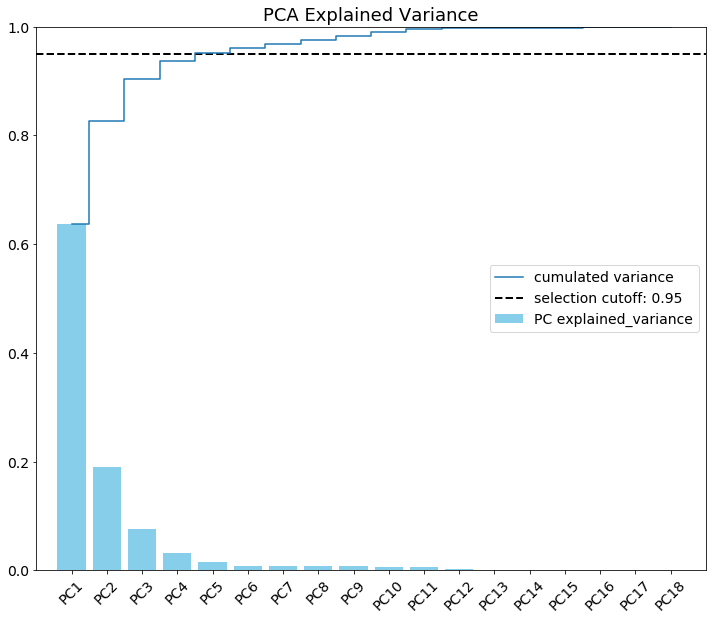

In [8]:
_, pca_data, pca_, pc_num = ScaleAndPCA(df_rrs_no_nans, var_threshold=0.95,
                                            verbose=False)

Now let's take a look at how the primary (as defined by pc_num, above) relate to the features they originate from. First trim the pca_data to retain the pc_num PCs and put them in a data frame, with appropriate labeling:

In [9]:
df_pca = pd.DataFrame(pca_data[:,:pc_num],
                      columns=['PC%d' %(i+1) for i in range(pc_num)],
                      index=df_rrs_no_nans.index)

Merge the pca dataframe defined above with the rrs dataframe:

In [10]:
dfrrs_w_pca = pd.merge(df_pca, df_rrs_no_nans, 'outer',
                        left_index=True,
                        right_index=True)

Compute dataframe pairwise (Pearson's) correlation. Remove Rrs labels from vertical and PC labels from the horizontal axes, and plot results with [seaborn's heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html) colored with the "balance" color map from [cmocean](http://matplotlib.org/cmocean/). 

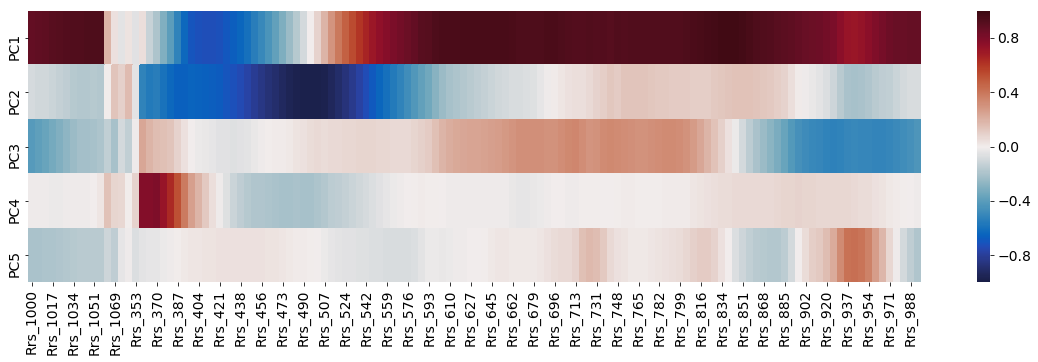

In [11]:
corr_w_pca = dfrrs_w_pca.corr()
corr_w_pca.drop(df_pca.columns, axis=1, inplace=True)
corr_w_pca.drop(df_rrs_no_nans.columns, axis=0, inplace=True)
f, ax = pl.subplots(figsize=(20, 5))
heatmap(corr_w_pca, cmap=cm.cm.balance, vmin=-1, vmax=1, ax=ax);

So to hand-wavily summarize the graph above; 
* PC1 appears to originate mostly from green to short-wave IR, with an interesting reversal in the low blue bands;
* PC2 seems to relate to the blue wavelengths;
* PC3, has some positive relation to red/near IR and negative relation to higher bands; * PC4 relates to a few bands low in the UV; 
* PC5 points mosly in the higher near-IR.

*Happy coding!*